<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_29908/2544565908.py:1: SyntaxWarning: invalid escape sequence '\S'
  """


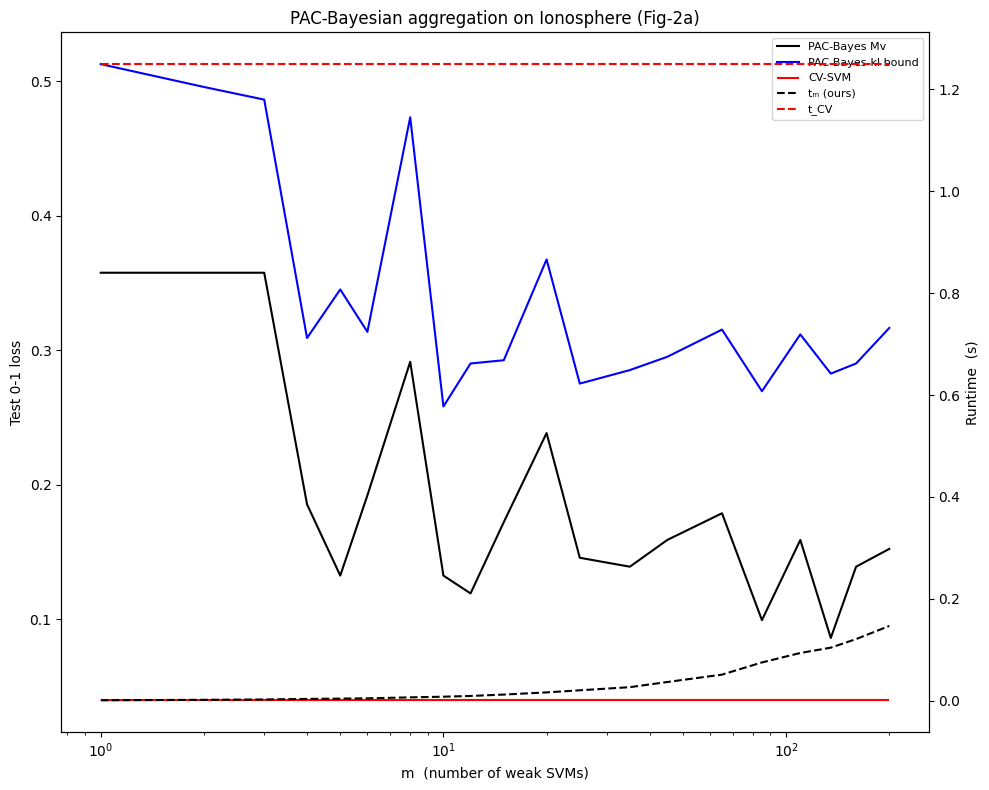

In [1]:
"""
Reproduce the data for Fig-2a in  
“A Strongly Quasiconvex PAC-Bayesian Bound”,  
Thiemann et al. (ALТ’17, arXiv:1608.05610v2).

Dataset : UCI Ionosphere  
Train set |S| = 200,  r = d+1 = 35               (weak‐learner train size)  
Test  set |T| = 150                              (remaining patterns)

For every value m in M = {1,2,4,… ,256}  
    1. draw m random subsets of size r from S  
    2. train one weak RBF-SVM per subset  
    3. compute its validation loss on S\Sh  
    4. minimise the PAC-Bayes-λ bound (δ = .05) by alternating
       (ρ,λ)-updates until convergence  
    5. evaluate the ρ-weighted majority vote on T, store its loss  
    6. keep wall–clock training time

The script finally draws the plot that appears as Fig-2a
(test-loss and run–time versus m, together with the cross–validated
single SVM baseline and the PAC-Bayes-kl bound curve).
"""
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import brentq
from scipy.spatial.distance import pdist
from scipy.special import logsumexp
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# ----------------------------------------------------------------------
# 1. load and preprocess Ionosphere (class -> {+1,-1}, scale features)
# ----------------------------------------------------------------------
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
df = pd.read_csv(url, header=None)
X = df.iloc[:, :-1].astype(float).values
y = (df.iloc[:, -1] == "g").astype(int).values  # 'g'→1 , 'b'→0

# shuffle once for reproducibility
rng = np.random.RandomState(42)
perm = rng.permutation(len(X))
X, y = X[perm], y[perm]

# split into train(200) / test(rest); keep scaler fitted on train
X_S, X_T, y_S, y_T = train_test_split(
    X, y, train_size=200, stratify=y, random_state=rng
)
scaler = StandardScaler().fit(X_S)
X_S, X_T = scaler.transform(X_S), scaler.transform(X_T)
n, d = X_S.shape
r = d + 1  # 35
n_r = n - r  # |validation| for each h
delta = 0.05


# ----------------------------------------------------------------------
# helper – loss, kl , inversion of kl (upper) via bisection
# ----------------------------------------------------------------------
def zero_one_loss(pred, true):
    return (pred != true).mean()


def kl(p, q):
    p = np.clip(p, 1e-12, 1 - 1e-12)
    q = np.clip(q, 1e-12, 1 - 1e-12)
    return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))


def kl_inv(p_hat, eps):
    """upper inverse of kl(p_hat||q) = eps  (returns smallest q≥p_hat)"""

    def f(q):
        return kl(p_hat, q) - eps

    return brentq(f, p_hat, 1 - 1e-12)


# ----------------------------------------------------------------------
# PAC-Bayes alternating minimisation for fixed losses
# ----------------------------------------------------------------------
def minimise_bound(L_val):
    """return ρ (m,), λ*, bound_value"""
    m = len(L_val)
    log_pi = -np.log(m) * np.ones(m)  # uniform prior
    lam = np.sqrt(np.log(2 * np.sqrt(n_r) / delta) / n_r)  # init
    # iterate
    for _ in range(30):
        log_rho = log_pi - lam * n_r * L_val
        log_rho -= logsumexp(log_rho)
        rho = np.exp(log_rho)
        KL = np.sum(rho * (log_rho - log_pi))
        L_emp = np.dot(rho, L_val)
        lam_new = 2.0 / (
            np.sqrt(2 * n_r * L_emp / (KL + np.log(2 * np.sqrt(n_r) / delta))) + 1 + 1
        )
        if abs(lam_new - lam) < 1e-4:
            lam = lam_new
            break
        lam = lam_new
    # bound on RANDOMISED classifier
    bound = L_emp / (1 - lam / 2) + (KL + np.log(2 * np.sqrt(n_r) / delta)) / (
        n_r * lam * (1 - lam / 2)
    )
    return rho, lam, bound


# ----------------------------------------------------------------------
# 2. baseline: single SVM tuned by 5-fold CV on full training set
# ----------------------------------------------------------------------
# ------------------------------------------------------------------
# Better γ–grid  (Jaakkola heuristic)
# ------------------------------------------------------------------

# pairwise distances only between samples of opposite labels
opp_pairs = pdist(X_S, "euclidean")
sigma = np.median(opp_pairs)  # Jaakkola’s σ
gamma0 = 1.0 / (2.0 * sigma**2 + 1e-12)

gamma_grid = [gamma0 * 10**k for k in [-4, -2, 0, 2, 4]]  # five values over 4 decades


c_grid = {"C": [10**k for k in range(-3, 4)], "gamma": gamma_grid}  # placeholder

# heuristic grid for gamma
# G = np.min(
#     [
#         np.linalg.norm(x1 - x2)
#         for x1, y1 in zip(X_S, y_S)
#         for x2, y2 in zip(X_S, y_S)
#         if y1 != y2
#     ]
# ).reshape(-1)
# gamma_seed = 1.0 / (2.0 * (np.median(G) ** 2 + 1e-12))
# c_grid["gamma"] = [gamma_seed * 10**k for k in range(-4, 5, 2)]

svc = SVC(kernel="rbf")
cv = GridSearchCV(svc, c_grid, cv=5, n_jobs=-1, verbose=0)
tic = time.time()
cv.fit(X_S, y_S)
t_cv = time.time() - tic
loss_cv = zero_one_loss(cv.predict(X_T), y_T)

# ----------------------------------------------------------------------
# 3. experiment: vary m , keep r fixed
# ----------------------------------------------------------------------
M = [
    1,
    2,
    3,
    4,
    5,
    6,
    8,
    10,
    12,
    15,
    20,
    25,
    35,
    45,
    65,
    85,
    110,
    135,
    160,
    200,
]  # [1, 2, 4, 8, 16, 32, 64, 128]
loss_mv, bound_vals, runtime = [], [], []

for m in M:
    tic = time.time()
    losses_val = np.zeros(m)
    preds_test = np.zeros((m, len(y_T)))
    for j in range(m):
        idx = rng.choice(n, r, replace=False)
        X_tr, y_tr = X_S[idx], y_S[idx]
        # validation indices
        mask_val = np.ones(n, dtype=bool)
        mask_val[idx] = False
        X_val, y_val = X_S[mask_val], y_S[mask_val]
        # random γ from same heuristic grid, C fixed (1)
        gamma = rng.choice(c_grid["gamma"])
        clf = SVC(kernel="rbf", C=1.0, gamma=gamma).fit(X_tr, y_tr)
        losses_val[j] = zero_one_loss(clf.predict(X_val), y_val)
        preds_test[j] = clf.predict(X_T)
    # minimise bound
    rho, lam, bound = minimise_bound(losses_val)
    # weighted majority vote
    mv_pred = (np.dot(rho, preds_test) >= 0.5).astype(int)
    loss_mv.append(zero_one_loss(mv_pred, y_T))
    bound_vals.append(
        kl_inv(
            np.dot(rho, losses_val),
            (np.sum(rho * np.log(rho * m)) + np.log(2 * np.sqrt(n_r) / delta)) / n_r,
        )
    )
    runtime.append(time.time() - tic)

loss_mv = np.array(loss_mv)
bound_vals = np.array(bound_vals)
runtime = np.array(runtime)

# ----------------------------------------------------------------------
# 4. draw figure  (test-loss + bound + runtime, vs m)
# ----------------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.set_xscale("log", base=10)
ax1.set_xlabel("m  (number of weak SVMs)")
ax1.set_ylabel("Test 0-1 loss")

ax1.plot(M, loss_mv, "k-", label="PAC-Bayes Mv")
ax1.plot(M, bound_vals, "b-", label="PAC-Bayes-kl bound")
ax1.hlines(loss_cv, M[0], M[-1], colors="r", linestyles="-", label="CV-SVM")

ax2 = ax1.twinx()
ax2.set_ylabel("Runtime  (s)")
ax2.plot(M, runtime, "k--", label="tₘ (ours)")
ax2.hlines(t_cv, M[0], M[-1], colors="r", linestyles="--", label="t_CV")

# combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right", fontsize=8)

ax1.set_title("PAC-Bayesian aggregation on Ionosphere (Fig-2a)")

plt.tight_layout()
plt.show()